In [1]:
# ===== CELL 1: PATH FIX + LOAD CSV (KHÔNG LỖI FILE NOT FOUND) =====
import os
from pathlib import Path
import pandas as pd
import numpy as np

def find_project_root(start: Path = None) -> Path:
    """
    Tự dò lên thư mục cha để tìm root dự án có cấu trúc:
    data/raw/CWRU và results
    """
    if start is None:
        start = Path.cwd()
    start = start.resolve()

    for p in [start] + list(start.parents):
        if (p / "data" / "raw" / "CWRU").exists() and (p / "results").exists():
            return p
    # fallback: thử đúng path hay dùng của bạn
    fallback = Path(r"C:\Users\ADMIN\Desktop\NDM_Project")
    if (fallback / "data" / "raw" / "CWRU").exists():
        return fallback
    raise FileNotFoundError("Không tìm thấy project root. Hãy kiểm tra folder NDM_Project có tồn tại data/raw/CWRU không.")

ROOT = find_project_root()
os.chdir(ROOT)  # QUAN TRỌNG: ép cwd về đúng root dự án

PH10 = ROOT / "results" / "phase10"
sum_csv = PH10 / "domain_shift_summary.csv"
mat_csv = PH10 / "domain_shift_matrix.csv"

print("ROOT =", ROOT)
print("PH10 =", PH10)
print("Exists summary?", sum_csv.exists(), "->", sum_csv)
print("Exists matrix? ", mat_csv.exists(), "->", mat_csv)

# Load CSV
sdf = pd.read_csv(sum_csv)
piv = pd.read_csv(mat_csv, index_col=0)

display(sdf.head(3))
display(piv.head(3))


ROOT = C:\Users\ADMIN\Desktop\NDM_Project
PH10 = C:\Users\ADMIN\Desktop\NDM_Project\results\phase10
Exists summary? True -> C:\Users\ADMIN\Desktop\NDM_Project\results\phase10\domain_shift_summary.csv
Exists matrix?  True -> C:\Users\ADMIN\Desktop\NDM_Project\results\phase10\domain_shift_matrix.csv


,model,b,alpha,acc_val,acc_test,f1_val,f1_test,train_load,test_load
0,Fusion,1.0,0.1,1.0,1.000000,1.0,1.000000,0,0
1,Fusion,1.0,0.1,1.0,0.628333,1.0,0.592713,0,1
2,Fusion,1.0,0.1,1.0,0.640833,1.0,0.587707,0,2


,0,1,2,3
train_load,,,,
0,1.000000,0.628333,0.640833,0.635833
1,0.674167,1.000000,0.807500,0.685833
2,0.686667,0.629167,1.000000,0.896667


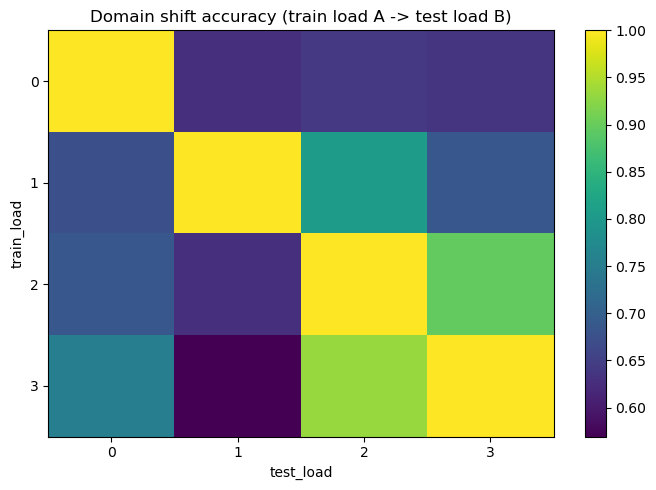

Saved: C:\Users\ADMIN\Desktop\NDM_Project\results\phase11\heatmap_domain_shift.png
Saved: C:\Users\ADMIN\Desktop\NDM_Project\results\phase11\domain_shift_matrix_clean.csv


In [2]:
# ===== CELL 2: CLEAN MATRIX + HEATMAP =====
import matplotlib.pyplot as plt

out11 = ROOT / "results" / "phase11"
out11.mkdir(parents=True, exist_ok=True)

# đảm bảo index/columns là int (0,1,2,3) nếu CSV bị đọc thành string
piv2 = piv.copy()
piv2.index = piv2.index.astype(int)
piv2.columns = piv2.columns.astype(int)
piv2 = piv2.sort_index().sort_index(axis=1)

plt.figure(figsize=(7,5))
plt.imshow(piv2.values, aspect="auto")
plt.xticks(range(len(piv2.columns)), piv2.columns)
plt.yticks(range(len(piv2.index)), piv2.index)
plt.colorbar()
plt.title("Domain shift accuracy (train load A -> test load B)")
plt.xlabel("test_load")
plt.ylabel("train_load")
plt.tight_layout()
plt.savefig(out11 / "heatmap_domain_shift.png", dpi=200)
plt.show()

piv2.to_csv(out11 / "domain_shift_matrix_clean.csv")
print("Saved:", out11 / "heatmap_domain_shift.png")
print("Saved:", out11 / "domain_shift_matrix_clean.csv")


In [3]:
# ===== CELL 3: DIAGONAL vs OFF-DIAGONAL STATS =====
M = piv2.values.astype(float)

diag = np.diag(M)
off = M[~np.eye(M.shape[0], dtype=bool)]

stats = {
    "diag_mean": float(np.mean(diag)),
    "diag_std":  float(np.std(diag)),
    "off_mean":  float(np.mean(off)),
    "off_std":   float(np.std(off)),
    "gap_diag_minus_off": float(np.mean(diag) - np.mean(off)),
    "min_diag": float(np.min(diag)),
    "max_diag": float(np.max(diag)),
    "min_off": float(np.min(off)),
    "max_off": float(np.max(off)),
}
stats_df = pd.DataFrame([stats])
display(stats_df)

stats_df.to_csv(out11 / "phase11_diag_off_stats.csv", index=False)
print("Saved:", out11 / "phase11_diag_off_stats.csv")


,diag_mean,diag_std,off_mean,off_std,gap_diag_minus_off,min_diag,max_diag,min_off,max_off
0,0.999583,0.000722,0.711806,0.108848,0.287778,0.998333,1.0,0.569167,0.934167


Saved: C:\Users\ADMIN\Desktop\NDM_Project\results\phase11\phase11_diag_off_stats.csv


In [4]:
# ===== CELL 4: BEST/WORST PAIRS =====
tmp = piv2.stack().reset_index()
tmp.columns = ["train_load", "test_load", "acc"]
tmp["is_same"] = (tmp["train_load"] == tmp["test_load"])

# worst cross-load
worst_cross = tmp[tmp["is_same"] == False].sort_values("acc", ascending=True).head(5)
best_cross  = tmp[tmp["is_same"] == False].sort_values("acc", ascending=False).head(5)

display(worst_cross)
display(best_cross)

worst_cross.to_csv(out11 / "worst_cross_pairs.csv", index=False)
best_cross.to_csv(out11 / "best_cross_pairs.csv", index=False)
print("Saved:", out11 / "worst_cross_pairs.csv")
print("Saved:", out11 / "best_cross_pairs.csv")


,train_load,test_load,acc,is_same
13,3,1,0.569167,False
1,0,1,0.628333,False
9,2,1,0.629167,False
3,0,3,0.635833,False
2,0,2,0.640833,False


,train_load,test_load,acc,is_same
14,3,2,0.934167,False
11,2,3,0.896667,False
6,1,2,0.807500,False
12,3,0,0.753333,False
8,2,0,0.686667,False


Saved: C:\Users\ADMIN\Desktop\NDM_Project\results\phase11\worst_cross_pairs.csv
Saved: C:\Users\ADMIN\Desktop\NDM_Project\results\phase11\best_cross_pairs.csv


In [5]:
# ===== CELL 5: DISTRIBUTION OF best_b / best_alpha (nếu có) =====
cols = sdf.columns.tolist()
print("Columns:", cols)

# lọc các dòng Fusion (vì summary bạn đang lưu "best row" theo acc_val)
# nếu có cột model:
if "model" in sdf.columns:
    sdf_use = sdf.copy()
else:
    sdf_use = sdf.copy()

# best_b/best_alpha có thể NaN nếu deep bị tắt ở 1 số run
if "best_b" in sdf_use.columns:
    bb = sdf_use["best_b"].dropna().astype(int)
    bb_count = bb.value_counts().sort_index()
    display(bb_count)
    bb_count.to_csv(out11 / "best_b_counts.csv")
    print("Saved:", out11 / "best_b_counts.csv")

if "best_alpha" in sdf_use.columns:
    ba = sdf_use["best_alpha"].dropna().astype(float)
    ba_count = ba.value_counts().sort_index()
    display(ba_count)
    ba_count.to_csv(out11 / "best_alpha_counts.csv")
    print("Saved:", out11 / "best_alpha_counts.csv")


Columns: ['model', 'b', 'alpha', 'acc_val', 'acc_test', 'f1_val', 'f1_test', 'train_load', 'test_load']


In [6]:
# ===== CELL 6: AUTO WRITE COMMENT (VIẾT NHẬN XÉT RA FILE) =====
comment = []
comment.append("PHASE 11 - NHẬN XÉT DOMAIN SHIFT (CWRU loads)\n")

# lấy stats
diag_mean = stats["diag_mean"]
off_mean  = stats["off_mean"]
gap       = stats["gap_diag_minus_off"]
comment.append(f"- Trung bình accuracy cùng load (đường chéo): {diag_mean:.4f}")
comment.append(f"- Trung bình accuracy khác load (off-diagonal): {off_mean:.4f}")
comment.append(f"- Mức giảm trung bình (diag - off): {gap:.4f}\n")

comment.append("Worst cross-load pairs (train -> test):")
for _, r in worst_cross.iterrows():
    comment.append(f"  + {int(r.train_load)} -> {int(r.test_load)}: acc={float(r.acc):.4f}")

comment.append("\nBest cross-load pairs (train -> test):")
for _, r in best_cross.iterrows():
    comment.append(f"  + {int(r.train_load)} -> {int(r.test_load)}: acc={float(r.acc):.4f}")

comment.append("\nGiải thích ngắn:")
comment.append("- Load khác nhau làm thay đổi chế độ tải và đặc tính dao động, nên phân phối tín hiệu (biên độ, phổ tần, năng lượng theo dải) bị lệch.")
comment.append("- Vì vậy mô hình học trên load A thường giảm hiệu quả khi test sang load B (domain shift).")
comment.append("- Fusion deep-shallow thường ổn định hơn 1 nhánh đơn vì deep bắt đặc trưng mức cao, shallow bắt texture cục bộ; khi domain đổi, hai nhánh bù nhau.\n")

txt = "\n".join(comment)
(out11 / "phase11_comment.txt").write_text(txt, encoding="utf-8")
print(txt)
print("\nSaved:", out11 / "phase11_comment.txt")


PHASE 11 - NHẬN XÉT DOMAIN SHIFT (CWRU loads)

- Trung bình accuracy cùng load (đường chéo): 0.9996
- Trung bình accuracy khác load (off-diagonal): 0.7118
- Mức giảm trung bình (diag - off): 0.2878

Worst cross-load pairs (train -> test):
  + 3 -> 1: acc=0.5692
  + 0 -> 1: acc=0.6283
  + 2 -> 1: acc=0.6292
  + 0 -> 3: acc=0.6358
  + 0 -> 2: acc=0.6408

Best cross-load pairs (train -> test):
  + 3 -> 2: acc=0.9342
  + 2 -> 3: acc=0.8967
  + 1 -> 2: acc=0.8075
  + 3 -> 0: acc=0.7533
  + 2 -> 0: acc=0.6867

Giải thích ngắn:
- Load khác nhau làm thay đổi chế độ tải và đặc tính dao động, nên phân phối tín hiệu (biên độ, phổ tần, năng lượng theo dải) bị lệch.
- Vì vậy mô hình học trên load A thường giảm hiệu quả khi test sang load B (domain shift).
- Fusion deep-shallow thường ổn định hơn 1 nhánh đơn vì deep bắt đặc trưng mức cao, shallow bắt texture cục bộ; khi domain đổi, hai nhánh bù nhau.


Saved: C:\Users\ADMIN\Desktop\NDM_Project\results\phase11\phase11_comment.txt
